# Re-referencing

One thing that can be hard to get your head around at first, when working with EEG data, is that the electrical potential values at each electrode are actually *relative* measurements. Specifically, The microVolt measurement at each electrode is the *difference* in electrical potential at that electrode, relative to a **reference electrode**. This is actually a fundamental property of electrical potential measurements — they are always a relative measure. To understand why, we need to understand electricity a bit more.



### What is an Electrical Potential Measurement?

Typically, when people think about electricity they think about the *flow* of electrical current through a conductor or device. For example, when you turn on a light switch, electrical current flows through the circuit (from a source, through wiring, to the light bulb, and then back into the building' wiring), creating illumination. However, when the light switch is off, the electrical circuit still has the *potential* for current to flow. 

A good analogy for this is to think about water, rather than electricity, because water is tangible and visible. If we place a bucket containing 10 L of water on a table, we have a *potential* for 10 L of water to move to some other location, such as the floor. If we connect a hose to an opening in the bucket, and run the hose down to the floor, we create a path through which the water can flow. Allowing the water to flow through the hose is equivalent to turning on the light switch in our earlier example — the flow of water is comparable to the electrical current flow. Note, however, that this example would not make sense if we held the bucket underwater in the ocean. If we did that, there would be no potential for water to flow out of the bucket, because it would be surrounded by water. In other words, when we say that a bucket on a table has potential for water to flow onto the floor, that's only because, in relative terms, there is 10 L more water in the bucket than on the floor.

Coming back to electricity, a closer example is the case of a battery, such as a standard AA battery. This has an electrical potential of 1.5 V. If it is placed in, say, a flashlight, and the flashlight is turned on, then current flows through the bulb and creates light. However, even with the flashlight turned off, the battery has 1.5 V of electrical potential. The way we would measure this potential is by connecting a device called a Voltmeter to either end of the battery (the *terminals*, marked `+` and `-`) — this would measure the difference in electrical potential between the two parts of the battery that would connect to an electrical circuit.

In all of these examples, we are measuring *potential* relative to some location/source that we treat as our reference. In the water example, there is 10 L more water on the table than on the floor. In the battery example, there is 1.5 V more electrical potential in the battery than in the device it's in, or the Voltmeter.

### Electrical Potentials in EEG

Coming back to EEG, when we measure electrical activity from the scalp, we are measuring the electrical *potential* at the location of the electrode — so it is necessarily relative to some other reference point. Ideally, we would have a reference point that is electrically neutral — that is, it has no electrical potential itself. However, this is technically challenging. For one thing, we want our reference point to be on the body of the person we are recording from, because otherwise we would be recording the difference in electrical potential between some external location and the *entire* body of the person. Since our bodies are ~80% water, with high electrolyte content, we absorb a lot of electromagnetic radiation from our environment. Thus if we measured electrical potential at the scalp relative to something neutral like the Earth, the data would contain all of the electromagnetic noise picked up by the body, and mixed in there somewhere, a comparatively weak EEG signal. In order to record only electrical activity in the brain, we need a reference point that is on the body, and ideally on the head. 

It turns out that this reference location doesn't actually need to be "neutral" in the sense of not detecting any neural activity. Since electrical potential is a relative measurement, any pair of reference and measurement electrodes on the head will generate a measurement of the electrical potential difference between those locations. So as long as the reference electrode is not too close to the recording electrode, then we will get an electrical potential value. This is *not* to say that our choice of reference location doesn't matter, however. Indeed, the choice of reference location will determine the size and polarity (positive/negative) of the voltage measured at each recording electrode. We will demonstrate this below. 

The reason that this information is relevant to our preprocessing of the data, is that it is possible to **re-reference** the data after recording, to any other location where we had a a recording electrode. This is done simply be subtracting the electrical potential from the new reference electrode from the values at every other electrode, at each time point. This is useful because it means that we don't need to be too concerned about our choice of reference electrode location during recording. 


## What reference was used in our data set?

Let's load the data and find out!

In [8]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import numpy as np
import matplotlib.pyplot as plt

# Participant ID code
p_id = 'sub-001'
data_dir = 'data/' + p_id + '/'

epochs = mne.read_epochs(data_dir + p_id + '-epo.fif', preload=True)


We can plot the locations of all of the channels on the head like this:

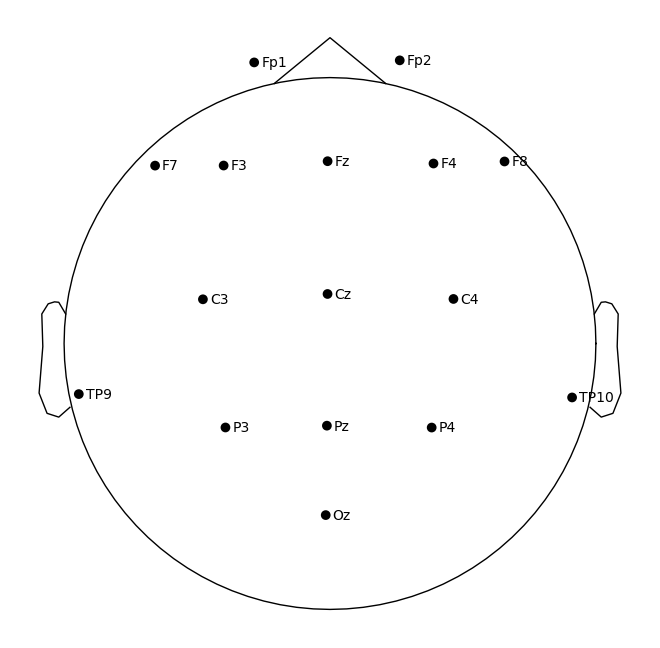

In [9]:
epochs.plot_sensors(show_names=True);


Unfortunately, by default the reference location is not recorded in the raw data file, and so it is not something we can find in one of the attributes of the `Raw` data set, or show on the montage. However, we know (since this data was collected in my lab, and we are always careful to document our procedures) that the reference electrode was located at the International 10-20 System position FCz, which is located along the midline of the scalp, halfway between electrodes Fz and Cz. We can plot all of the channels in the International 10-20 system like this:

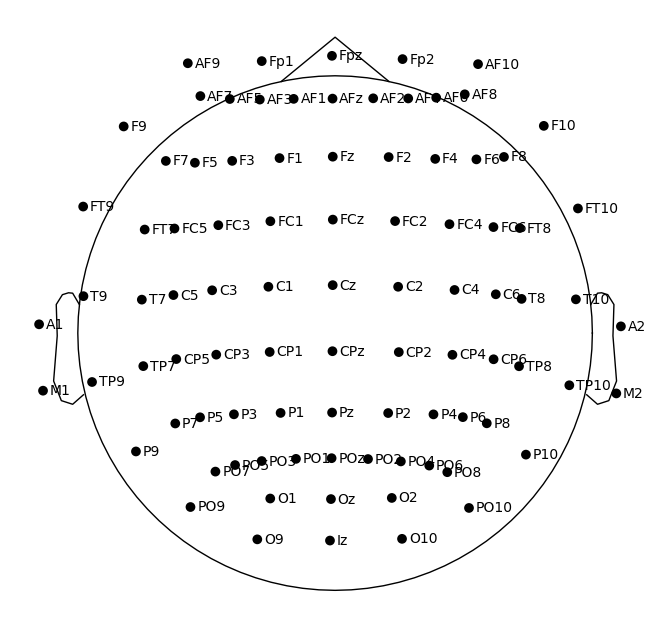

In [10]:
std_montage = mne.channels.make_standard_montage("easycap-M1")
std_montage.plot();

The fact that the reference electrode was positioned between Fz and Cz means that we would expect the EEG at those two channels to be quite flat, since they are measuring nearly the same electrical activity. If we plot each of the midline channels, we can see that this is indeed the case:

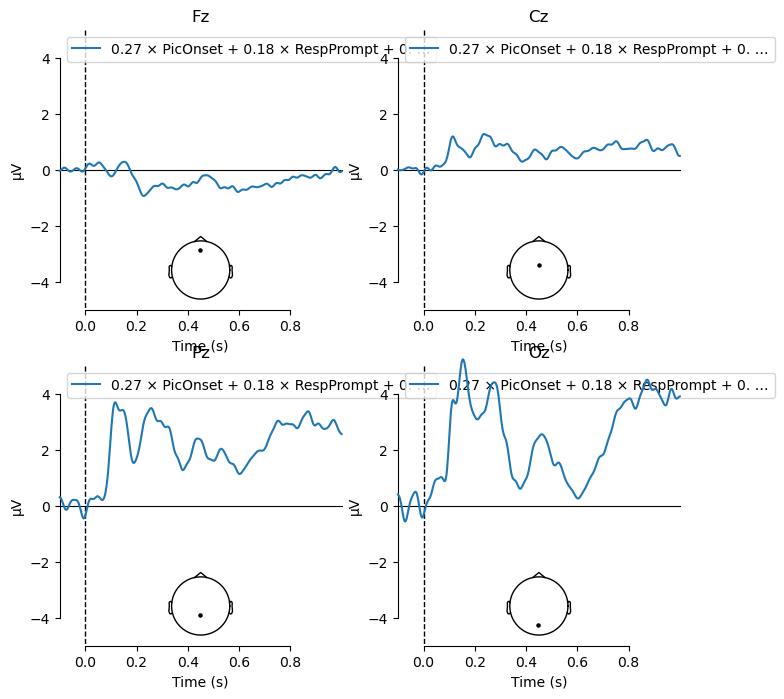

In [12]:
# define the channels we want plots for
channels = ['Fz', 'Cz', 'Pz', 'Oz']

# create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# plot each channel in a separate subplot
for idx, chan in enumerate(channels):
    mne.viz.plot_compare_evokeds(epochs.copy().average(), 
                                picks=chan,
                                combine='mean', 
                                ylim={'eeg':(-5, 5)},
                                show_sensors='lower center',
                                axes=axes.reshape(-1)[idx],
                                show=False
                                );
plt.show()    

The FCz reference location also explains why, in the scalp topography maps (re-plotted below), the area between electrodes Fz and Cz is white, or very close to it, at most time points. As indicated on the color bar below, white represents a value of zero. The values aren't exactly zero/white in the plots below, because in generating these plots, MNE interpolates values in between the electrodes. In other words, we only have voltage measurements at each electrode (the dots in the plots), and the colors at every other location are determined by mathematical estimates of what the voltage values likely would have been, based on the values at the electrodes we do have. Since both Fz and Cz measure slightly different locations than the reference, they are not zero, and the estimated values between them may also not be zero due to noise. 

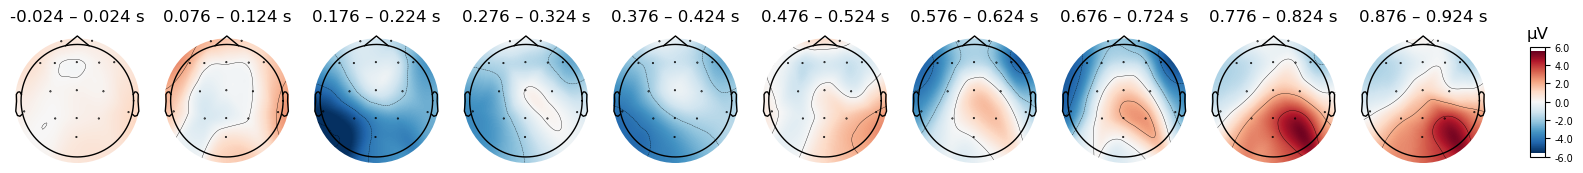

In [13]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, np.max(epochs.times), 0.1)

epochs['Match'].average().plot_topomap(times=times, average=0.050);

## What reference to select in preprocessing?

While the choice of reference during recording is somewhat arbitrary, the choice of what to use as a reference in preprocessing is, however, an important one. Since this choice will influence the amplitude values at each channel, it will influence where ERP effects are identified, their polarity, and possibly how large they are.

A starting point for deciding on the re-referencing location is prior literature. In most areas of EEG/ERP research, there is an existing literature on the process and/or components of interest, and in many cases different research groups working on a topic will have converged on a common choice for reference location. Often this is a location that is relatively distant from the scalp location where the component(s) of interest are largest. For example in studies of face perception, the nose, or bridge of the nose, is often used because this is far from the area behind the ears where the N170 ERP component elicited by faces is largest. In contrast, in studies of language, the mastoid processes (the bony area right behind the ears) is used as the reference because this location is far from the top of the head, where the N400 and other components associated with language processing are largest. In this case, the potentials are averaged from the left and right mastoid locations, and then subtracted from every other electrode. This highlights another important consideration: since the brain is organized into two hemispheres, and many functions (such as language) tend to be lateralized to one hemisphere, it is good practice to choose a reference location that is either along the midline of the scalp (like the nose), or to average electrodes located over the left and right sides of the head.


### Average reference

An alternative to selecting a specific electrode(s) to re-reference to, is to use the average reference. In this case, the average potential across *all* electrodes is subtracted from each individual electrode. In principle, this is the ideal choice of reference because if all of the electrical activity recorded is from the brain, then the average electrical potential around the entire head should be zero. This is true because each source of electrical activity in the brain is an electrical *dipole*, with positive and negative values radiating out from the source in opposite directions. So, if we placed electrodes around the entire head with equal spacing between them, we would record the positive and negative potentials from each dipole source in the brain, which would sum to zero. Thus, at each channel the potential would reflect the relative potential at that scalp location relative to zero. However, in practice the situation is less ideal. Because of the fact that the head is attached to the neck (which we normally view as a Good Thing), we cannot place electrodes evenly around the entire head. Indeed, in practice EEG caps cover only the top half of the head, and typically the actual electrode positions cover a bit less than that. 

However, even in such less-than-ideal situations the average reference can be a good choice, because then the electrical potential at each scalp location still reflects what is unique to that position on the head relative to all other positions (from which we have recordings). There are a few limitations of average reference to keep in mind though. 

For one, if the experiment is designed to elicit an ERP component that is known to be quite large and extensive over the head, the average reference may not be a good choice. For instance, some components such as the P3 and N400 tend to be largest over the top of the head, but extend outward across many more channels. So if the same component is present at all or most of the channels used, then an average reference will effectively subtract that component from the data.  

A related consideration is the number of electrodes used during recording, and their locations. Average reference will work best when more electrodes used, and when more of the surface area of the head is covered by these electrodes. More electrodes both allow for more extensive scalp coverage, and ensure that the average is not biased by a few electrodes that have large potentials — including electrodes that may contain noise. Noisy electrodes are an issue for average reference because if there is high noise in a single electrode it will effectively be introduced into every other electrode by the averaging procedure, when it is used as a reference. More extensive coverage will mean that there is less likelihood that a widely-distributed component is subtracted in the average (because there will be more electrodes that aren't located over scalp regions where the component is present). 

### Re-Reference Our Data to the Average Reference

 demonstrate how to re-reference, and what the average reference looks like for this data set, as a way of understanding the effects of different reference location choices. Scalp topography maps are the best way to visualize the effects of re-referencing, since this procedure primarily affects the distribution of electrical potentials over the scalp. MNE provides a `.set_eeg_reference()` method for this purpose. 

We're only computing this average reference for demonstration purposes, so we don't assign the re-referenced data to a variable name, we just compute the average reference and plot it. So we chain re-referencing this with a few other methods:
- first we average all the epochs together
- then we re-reference to the average of all electrodes
- then we plot the results as topomaps

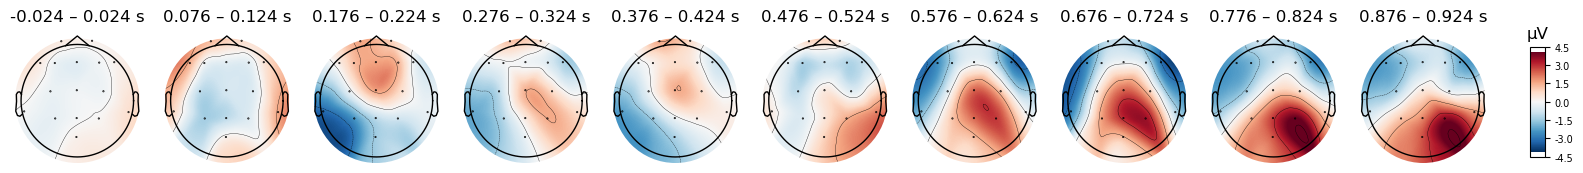

In [25]:
epochs['Match'].average().set_eeg_reference(ref_channels='average').plot_topomap(times=times, average=.050);

Compared to the previous set of topomaps above, we can see that the average reference shows a large negative potential over the top of the head, especially around electrodes Fz and Cz. Notably, however, the overall distribution of electrical activity is similar between the original and average-referenced data. For example, the voltage at the back of the head is still positive relative to the top/centre of the scalp.

## Re-Reference the Data to Averaged Mastoids

Now we will re-reference to the average of the mastoid electrodes (whose labels are Tp9 and TP10 in the 10-20 system — refer back to the plot of channel locations). Since this is the reference that we will want to work with, we assign the result to a new `Epochs` object, called `epochs_mastoidref`, and then plot it in a separate step.

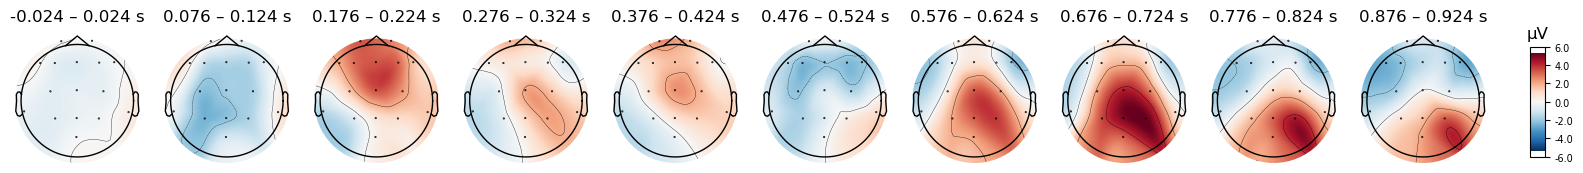

In [15]:
epochs_mastoidref = epochs.set_eeg_reference(ref_channels=['TP9', 'TP10']);

epochs_mastoidref['Match'].average().plot_topomap(times=times, average=.050);

Again, the relative distribution of electrical potentials across the scalp is similar to the original and average-referenced data. However, now the white, "zero voltage" area overlaps the locations behind the ears, and the top/centre electrodes (extending to more frontal electrodes) are more negative than when other references were used. 

## Save the Average Mastoid Re-referenced Data

In [ ]:
epochs_mastoidref.save(data_dir + p_id + '-mstd-epo.fif',
                      overwrite=True)

## Effects of Re-Referencing on Difference Waves

The above examples showed that the distribution of voltage values is consistent across different reference locations. While the actual values at each electrode change depending on the reference, the relative differences between different channels are preserved. However, when we compute difference waves, there are less intuitive effects of re-referencing. 

We can load the `Mismatch – Match` difference waves we created in the previous lesson. Note that MNE saves `Evoked` data as a list, even when there is only one Evoked object. Thus in the code below, we need to index the first element of the list, `[0]`, so that `evokeds_diff` is the Evoked object and not a list.

In [26]:
evokeds_diff = mne.read_evokeds(data_dir + p_id + '-diff-ave.fif')[0]

In [27]:
evokeds_diff

<Evoked | 'Mismatch - Match' (average, N=34), -0.1 – 1 s, baseline -0.1 – 0 s, 16 ch, ~95 kB>

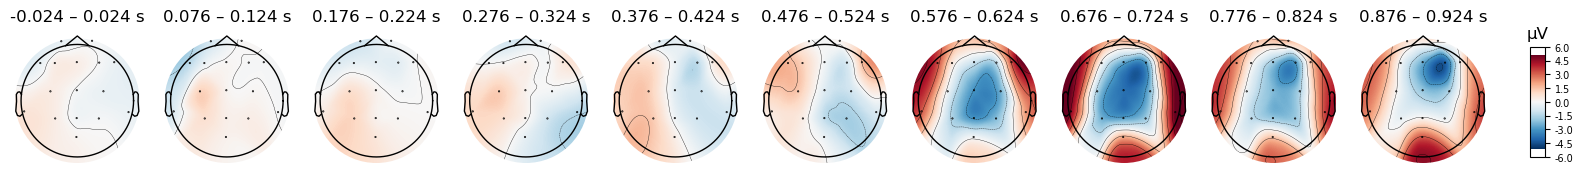

In [28]:
evokeds_diff.set_eeg_reference(ref_channels='average').plot_topomap(times=times, average=.050);

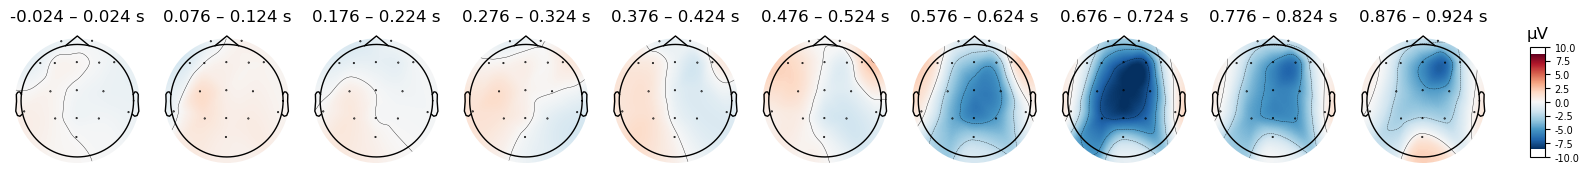

In [29]:
evokeds_diff.set_eeg_reference(ref_channels=['TP9', 'TP10']).plot_topomap(times=times, average=.050);